# LLMTime approach

In [1]:
import pandas as pd

# Load the traffic volume dataset
file_path = 'llmtime_data/taxi_volume_train.csv'
data = pd.read_csv(file_path)

# data head
data.head()


,start_volume,end_volume,region,time_interval
0,64.0,39.0,0,0
1,88.0,108.0,0,1
2,102.0,129.0,0,2
3,96.0,107.0,0,3
4,69.0,86.0,0,4


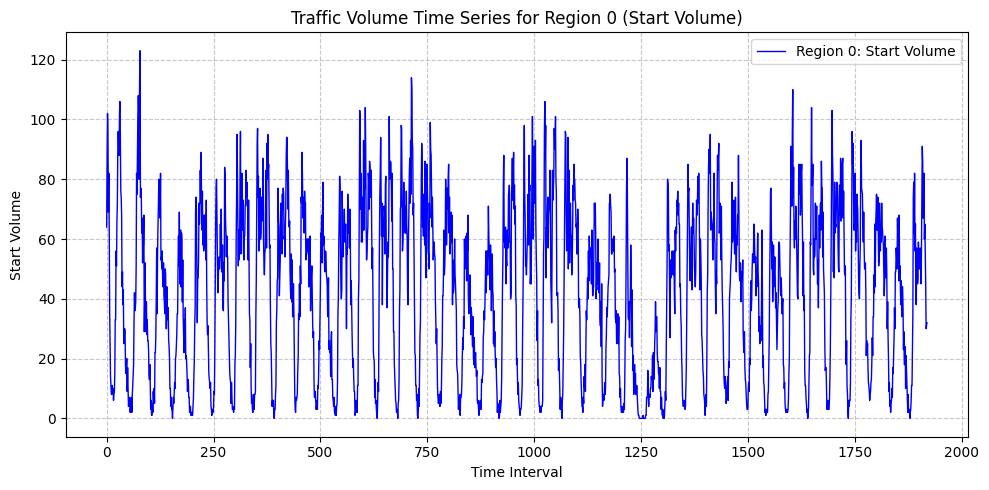

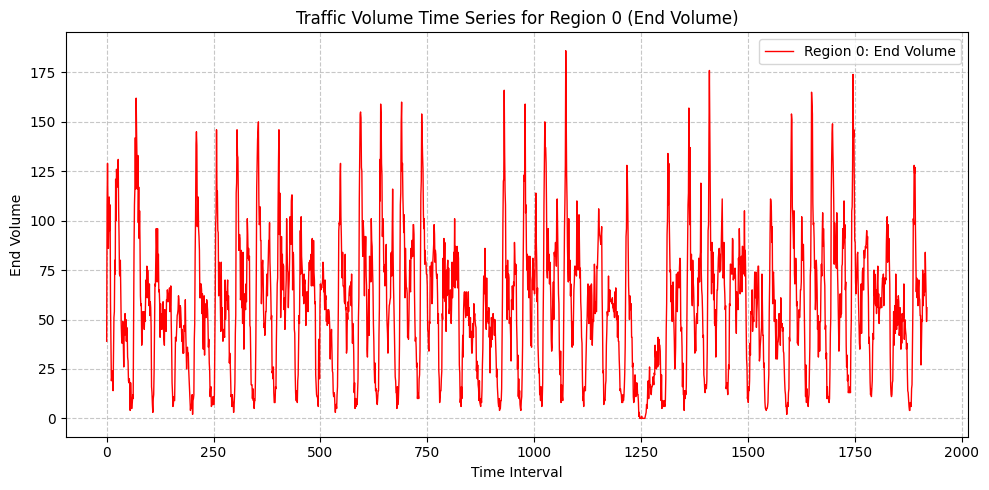

In [2]:
import matplotlib.pyplot as plt

# Filter data for Region 0
region_0_data_start = data[data['region'] == 0]['start_volume']

# Plot the traffic volume for Region 0 (Start Volume)
plt.figure(figsize=(10, 5))
plt.plot(region_0_data_start, label='Region 0: Start Volume', color='blue', linewidth=1)
plt.title('Traffic Volume Time Series for Region 0 (Start Volume)')
plt.xlabel('Time Interval')
plt.ylabel('Start Volume')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Filter data for Region 0 (End Volume)
region_0_data_end = data[data['region'] == 0]['end_volume']

# Plot the traffic volume for Region 0 (End Volume)
plt.figure(figsize=(10, 5))
plt.plot(region_0_data_end, label='Region 0: End Volume', color='red', linewidth=1)
plt.title('Traffic Volume Time Series for Region 0 (End Volume)')
plt.xlabel('Time Interval')
plt.ylabel('End Volume')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Normalization of Traffic Volume (for region 0)

The traffic volume data is filtered and normalized to a range between 0 and 1. This preprocessing step aligns with the methodology discussed in the LLMTime paper, where numerical values are scaled to fit within a fixed range. Normalization ensures that the data representation remains compact and consistent, optimizing the input for tokenization and modeling by the language model. The normalization is performed using the trivial formula:

![normalization](images/normalization_formula.png)

where \( x_{min} \) and \( x_{max} \) are the minimum and maximum values of the data, respectively. This step is crucial to avoid large numerical values consuming additional tokens and ensures compatibility with the model's context window.


In [3]:
# Filter data for region 0 and select 'start_volume' for modeling
region_0_data = data[data['region'] == 0]['start_volume']

# Normalize the 'start_volume' column to a range of 0-1
normalized_data = (region_0_data - region_0_data.min()) / (region_0_data.max() - region_0_data.min())

# Display the first few rows of the normalized data
normalized_data.head()


0    0.520325
1    0.715447
2    0.829268
3    0.780488
4    0.560976
Name: start_volume, dtype: float64

# Tokenization of Normalized Data for Language Model Input

We convert the normalized traffic volume data into a tokenized string format suitable for input to the LLM. Each normalized value is scaled by 100 to represent it as an integer with two decimal places of precision. The data is then encoded into a comma-separated string of integers, where each integer corresponds to a two-digit token.

The primary purpose of this transformation is to align with the numerical encoding strategy of the LLM, ensuring that each digit or number occupies minimal tokens in the model's context window. By tokenizing the data in this way, the model can better understand and process the sequential numerical data for zero-shot time series forecasting.

For example:
- Normalized values: [0.52, 0.71, 0.82] 
- Scaled and tokenized representation: `"52, 71, 82"`

In [4]:
# Convert normalized data to a string format for tokenization
# Multiply by 100 to represent values as integers with 2 decimal precision
tokenized_data = ", ".join(f"{int(value * 100):02d}" for value in normalized_data)

# Display the first 200 characters of the tokenized string to verify
tokenized_data[:200]


'52, 71, 82, 78, 56, 66, 51, 29, 20, 11, 08, 06, 06, 08, 07, 08, 04, 06, 07, 12, 26, 26, 45, 41, 53, 58, 72, 78, 73, 71, 82, 86, 76, 61, 60, 55, 35, 39, 30, 34, 20, 21, 24, 23, 14, 12, 13, 16, 07, 13, '

# Hugging Face

In [13]:
import os
from google.colab import userdata
from huggingface_hub import login

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

login(os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the LLaMA model and tokenizer
model_name = "meta-llama/Llama-2-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Prepare the input prompt
llama_input = f"Time series data: {truncated_data} \nPredict the next values:"
input_ids = tokenizer.encode(llama_input, return_tensors="pt")

# Generate predictions
with torch.no_grad():
    output_ids = model.generate(input_ids, max_length=1024, num_return_sequences=1)

# Decode the output to text
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Extract and display the predictions
print("Predicted values:", output_text.split("Predict the next values:")[-1].strip())


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b.
401 Client Error. (Request ID: Root=1-67558fb4-33e5d66e7fa038f56e3b05b9;39a0cf6a-abb9-45d0-87f8-ee571464b7e9)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b is restricted. You must have access to it and be authenticated to access it. Please log in.

# Ollama

Using llama2 with the tag `-text` since it refers to the pre-trained base model and not to the finetuned chat verison

In [15]:
!ollama pull llama2:13b-text

pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling a42778cb0676... 100% ▕████████████████▏ 7.4 GB                         
pulling 8c17c2ebb0ea... 100% ▕████████████████▏ 7.0 KB                         
pulling 7c23fb36d801... 100% ▕████████████████▏ 4.8 KB                         
pulling be397aec1145... 100% ▕████████████████▏  410 B                         
verifying sha256 digest 
writing manifest 
success 


### Spatio-temporal prompting

In [13]:
# Filter data for region 0
region_0_data = data[data["region"] == 0]

# Extract 200 data points from the start and end
start_data = region_0_data.iloc[:200]
end_data = region_0_data.iloc[-200:]
selected_data = pd.concat([start_data, end_data])

# Create a timestamp column for the entire region 0 data
region_0_data = region_0_data.copy()
region_0_data['timestamp'] = pd.date_range(
    start="2020-01-07 08:30", periods=len(region_0_data), freq="30T"
)

# Use the correct timestamps for the selected data
selected_data["timestamp"] = pd.concat([
    region_0_data.iloc[:200]["timestamp"],
    region_0_data.iloc[-200:]["timestamp"]
])

print(selected_data.head())
print(selected_data.tail())

# Adjust the dynamic prompt based on the extracted data
historical_start_time = selected_data["timestamp"].iloc[0]
historical_end_time = selected_data["timestamp"].iloc[-1]
next_prediction_start = historical_end_time + pd.Timedelta(minutes=30)
next_prediction_end = next_prediction_start + pd.Timedelta(minutes=30 * 11)

prompt_template = (
    "Temporal Information: The recording time of the historical data is '{} to {}, "
    "with data points recorded at 30-minute intervals'. Now we want to predict the taxi "
    "inflow and outflow for the next 12 time steps during the time period of '{} to {}, "
    "with data points recorded at 30-minute intervals'"
)

dynamic_prompt = prompt_template.format(
    historical_start_time.strftime("%B %d, %Y, %H:%M, %A"),
    historical_end_time.strftime("%B %d, %Y, %H:%M, %A"),
    next_prediction_start.strftime("%B %d, %Y, %H:%M, %A"),
    next_prediction_end.strftime("%B %d, %Y, %H:%M, %A"),
)

# Display the updated dynamic prompt
dynamic_prompt


   start_volume  end_volume  region  time_interval           timestamp
0          64.0        39.0       0              0 2020-01-07 08:30:00
1          88.0       108.0       0              1 2020-01-07 09:00:00
2         102.0       129.0       0              2 2020-01-07 09:30:00
3          96.0       107.0       0              3 2020-01-07 10:00:00
4          69.0        86.0       0              4 2020-01-07 10:30:00
      start_volume  end_volume  region  time_interval           timestamp
1915          56.0        84.0       0           1915 2020-02-16 06:00:00
1916          45.0        71.0       0           1916 2020-02-16 06:30:00
1917          30.0        61.0       0           1917 2020-02-16 07:00:00
1918          31.0        49.0       0           1918 2020-02-16 07:30:00
1919          32.0        56.0       0           1919 2020-02-16 08:00:00


"Temporal Information: The recording time of the historical data is 'January 07, 2020, 08:30, Tuesday to February 16, 2020, 08:00, Sunday, with data points recorded at 30-minute intervals'. Now we want to predict the taxi inflow and outflow for the next 12 time steps during the time period of 'February 16, 2020, 08:30, Sunday to February 16, 2020, 14:00, Sunday, with data points recorded at 30-minute intervals'"

### LLMTime direct prompting

In [16]:
import numpy as np
import random

max_length = 200
n_predicted_values = 30

# Randomly select a starting index for the subsection (ensure we have enough data)
start_index = random.randint(0, len(normalized_data) - 300)
print("Selected start index:", start_index)

# Extract the subsection for input (index 100 to 300 in this example)
input_subsection = normalized_data.iloc[start_index:start_index + max_length]

# Tokenize the input subsection
tokenized_input = ", ".join(f"{int(value * 100):02d}" for value in input_subsection)

# Extract the ground truth for comparison (index 300 to 320)
ground_truth = normalized_data.iloc[start_index + max_length:start_index + max_length + n_predicted_values]

print("Input subsection: \n", input_subsection[:5])
print("Tokenized Input:", tokenized_input[:50])
print("\nGround Truth: \n", ground_truth)


Selected start index: 775
Input subsection: 
 775    0.056911
776    0.040650
777    0.048780
778    0.065041
779    0.032520
Name: start_volume, dtype: float64
Tokenized Input: 05, 04, 04, 06, 03, 03, 07, 04, 07, 15, 19, 33, 33

Ground Truth: 
 975     0.463415
976     0.674797
977     0.796748
978     0.609756
979     0.544715
980     0.414634
981     0.422764
982     0.390244
983     0.439024
984     0.495935
985     0.528455
986     0.609756
987     0.471545
988     0.715447
989     0.617886
990     0.634146
991     0.365854
992     0.390244
993     0.365854
994     0.504065
995     0.674797
996     0.821138
997     0.691057
998     0.487805
999     0.707317
1000    0.739837
1001    0.585366
1002    0.593496
1003    0.756098
1004    0.528455
Name: start_volume, dtype: float64


In [17]:
import ollama
from sklearn.metrics import mean_squared_error

print("Tokenized data:", tokenized_input[:50])

#
max_chars_output = n_predicted_values * 4

# prompt for prediction
prompt = tokenized_input

# LLaMA model
response = ollama.chat(model='llama2:13b-text', messages=[
    {
        'role': 'user',
        'content': prompt,
    },
], options={"temperature": 0.8, "top_p": 0.9, "num_predict": max_chars_output})

# Extract the predicted values
predicted_values = response['message']['content']
print("Predicted values:", predicted_values)

# Function to parse the predicted values
def parse_predicted_values(predicted_values):
    return [int(value) / 100 for value in predicted_values.split(", ") if value]

# Parse the predictions into a list
parsed_predictions = parse_predicted_values(predicted_values)
print("Parsed Predictions:", parsed_predictions)

Tokenized data: 05, 04, 04, 06, 03, 03, 07, 04, 07, 15, 19, 33, 33
Predicted values: , 35, 25, 25, 21, 27, 32, 39, 42, 45, 46, 50, 57, 49, 46, 58, 44, 42, 38, 43, 50, 37, 41, 42, 39, 31, 27, 25, 25, 20, 28
Parsed Predictions: [0.35, 0.25, 0.25, 0.21, 0.27, 0.32, 0.39, 0.42, 0.45, 0.46, 0.5, 0.57, 0.49, 0.46, 0.58, 0.44, 0.42, 0.38, 0.43, 0.5, 0.37, 0.41, 0.42, 0.39, 0.31, 0.27, 0.25, 0.25, 0.2, 0.28]


Mean Squared Error (MSE): 0.07263814153832596


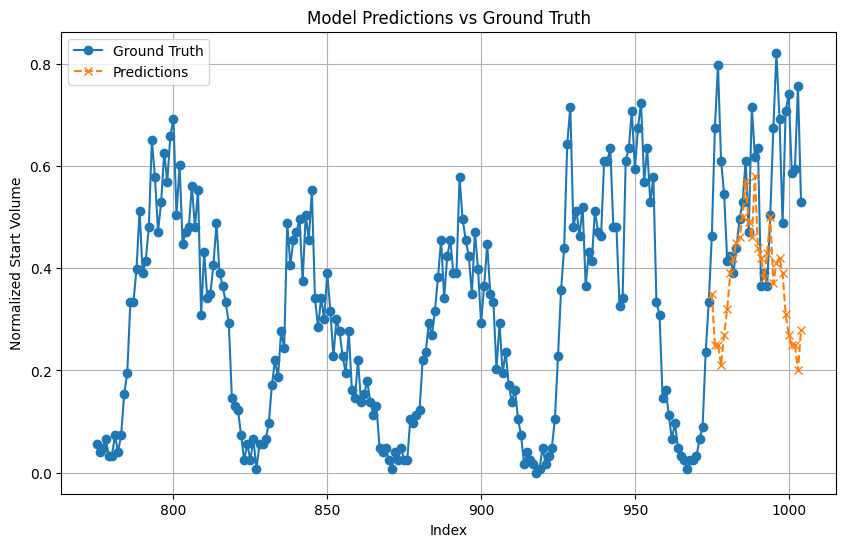

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Ensure predictions and ground truth have the same length for comparison
predictions_to_compare = parsed_predictions[:len(ground_truth)]

# Convert ground truth to a numpy array for comparison
ground_truth_values = ground_truth.values[:len(predictions_to_compare)]

# Evaluate the MSE
mse = mean_squared_error(ground_truth_values, predictions_to_compare)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.figure(figsize=(10, 6))

# Combine input subsection and ground truth
combined_ground_truth = normalized_data.iloc[start_index:start_index + max_length + len(ground_truth)].values

# Plot the entire ground truth (input + prediction range)
plt.plot(range(start_index, start_index + len(combined_ground_truth)),
         combined_ground_truth, label="Ground Truth", marker="o")

# Plot predictions aligned with their start index
plt.plot(range(start_index + max_length, start_index + max_length + len(predictions_to_compare)),
         predictions_to_compare, label="Predictions", linestyle="--", marker="x")

# Customize Plot
plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Index")
plt.ylabel("Normalized Start Volume")
plt.legend()
plt.grid(True)
plt.show()
